In [13]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [14]:
mix_111_sensor1 = pd.read_excel('data/time_data/ratio_111/Sensor 1_111.xlsx')
mix_111_sensor2 = pd.read_excel('data/time_data/ratio_111/Sensor 2_111.xlsx')
mix_111_sensor3 = pd.read_excel('data/time_data/ratio_111/Sensor 3_111.xlsx')

mix_111 = pd.DataFrame()
mix_111['Dilution'] = mix_111_sensor1['Dilutions']
mix_111['Sensor1'] = mix_111_sensor1['Voltage sensor1_111']
mix_111['Sensor2'] = mix_111_sensor2['Voltage_sensor2_111']
mix_111['Sensor3'] = mix_111_sensor3['Voltage _sensor3_111']
mix_111['Label'] = ['Mix_111' for i in range(len(mix_111))]
mix_111 = mix_111[['Dilution','Sensor1','Sensor2','Sensor3','Label']]

analyte1 = pd.read_csv('data/unsampled/Unsampled_Analyte1.csv').drop(['CFU/mL'], axis=1)
analyte2 = pd.read_csv('data/unsampled/Unsampled_Analyte2.csv').drop(['CFU/mL'], axis=1)
analyte3 = pd.read_csv('data/unsampled/Unsampled_Analyte3.csv').drop(['CFU/mL'], axis=1)

analyte1['Dilution'] = mix_111['Dilution']
analyte1['Label'] = ['A1' for i in range(len(analyte1))]

analyte2['Dilution'] = mix_111['Dilution'] 
analyte2['Label'] = ['A2' for i in range(len(analyte2))]

analyte3['Dilution'] = mix_111['Dilution']
analyte3['Label'] = ['A3' for i in range(len(analyte3))]

analyte1 = analyte1[['Dilution','Sensor1','Sensor2','Sensor3','Label']]
analyte2 = analyte2[['Dilution','Sensor1','Sensor2','Sensor3','Label']]
analyte3 = analyte3[['Dilution','Sensor1','Sensor2','Sensor3','Label']]


mix_101 = pd.read_excel('data/time_data/ratio_101/all_sensors_101.xlsx').drop(['Dilutions'],axis=1)
mix_101['Sensor1'] = mix_101['Voltage _sensor1_analyte1_analyte3(1:1)']
mix_101['Sensor2'] = mix_101['Voltage _sensor2_analyte1_analyte3(1:1)']
mix_101['Sensor3'] = mix_101['Voltage _sensor3_analyte1_analyte3(1:1)']
mix_101 = mix_101.drop(['Voltage _sensor1_analyte1_analyte3(1:1)','Voltage _sensor2_analyte1_analyte3(1:1)','Voltage _sensor3_analyte1_analyte3(1:1)'], axis=1)
mix_101['Dilution'] = mix_111['Dilution']
mix_101['Label'] = ['Mix_101' for i in range(len(mix_101))]
mix_101 = mix_101[['Dilution','Sensor1','Sensor2','Sensor3','Label']]

In [15]:
total_new_data = pd.concat([analyte1, analyte2, analyte3, mix_111, mix_101], axis=0).reset_index(drop=True)

total_new_data.to_csv('data/mixture/total_new_data(5 mixtures).csv', index=False)
total_new_data.to_excel('data/mixture/total_new_data(5 mixtures).xlsx', index=False)

del analyte1, analyte2, analyte3, mix_111, mix_101, mix_111_sensor1, mix_111_sensor2, mix_111_sensor3

### PCA  

In [16]:
labels = total_new_data['Label']
labels = labels.map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})

total_new_data = total_new_data.drop(['Dilution','Label'], axis=1)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(total_new_data)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

X_train, X_test, Y_train, Y_test = train_test_split(pca_data, labels, test_size=0.2, random_state=42)

pca_data.head()

,PC1,PC2
0,-55.202860,81.835563
1,-88.932533,61.649759
2,-109.967696,-6.291737
3,-121.811320,-20.589443
4,-125.253201,-22.830231


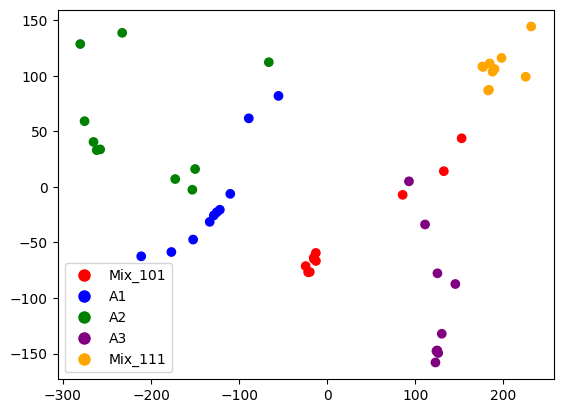

In [17]:
import matplotlib.pyplot as plt

label_mapping = {0:'Mix_101', 1:'A1',2: 'A2',3: 'A3', 4:'Mix_111'}

colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange'}
plt.scatter(pca_data['PC1'], pca_data['PC2'], c=labels.map(colors))
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label_mapping[label]) for label, color in colors.items()])
plt.show()

### SVM on 5 Classes

Training accuracy =  0.9
Testing accuracy =  0.8


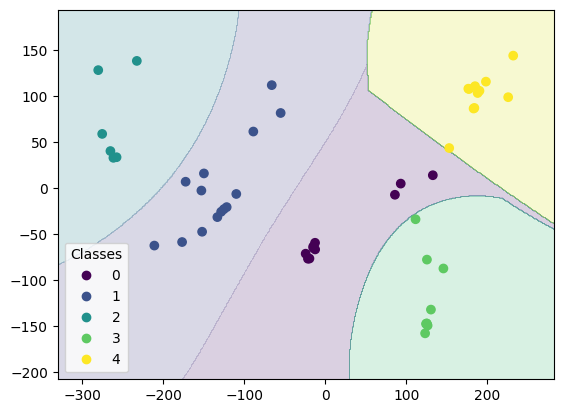

In [19]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)

print('Training accuracy = ', svm.score(X_train, Y_train))

pred = svm.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))


predictions = svm.predict(pca_data)

x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

### Random Forest

Training accuracy =  1.0
Testing accuracy =  0.8


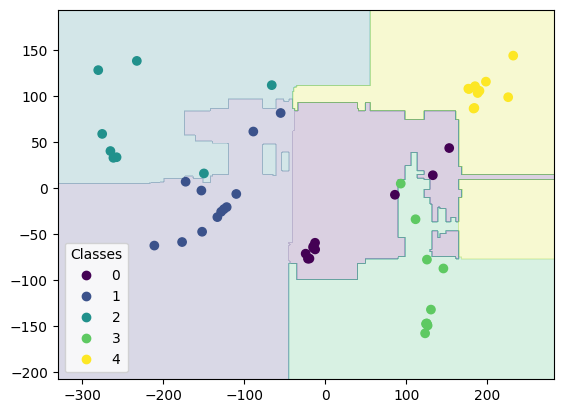

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)

print('Training accuracy = ', rfc.score(X_train, Y_train))

pred = rfc.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))


predictions = rfc.predict(pca_data)

x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()